In [2]:
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
S0 = 100      # Initial price
K = 120       # Strike
T = 1         # Maturity (years)
sig = 0.2     # Volatility
r = 0.05      # Risk-free rate

# Black-Scholes

In [4]:
def black_scholes(S0, K, T, r, sig, option_type):
    assert option_type in ('call', 'put')
    d1 = (math.log(S0 / K) + (r + 0.5 * sig ** 2) * T) / (sig * math.sqrt(T))
    d2 = d1 - sig * math.sqrt(T)
    c = S0 * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    p = -S0 * norm.cdf(-d1) + K * math.exp(-r * T) * norm.cdf(-d2)
    return c if option_type == 'call' else p

# Binomial Tree

In [5]:
def binomial_tree(N, S0, K , T, r, sig, option_type='call'):
    assert option_type in ('call', 'put')
    dt = T / N
    u = math.exp(sig * math.sqrt(dt))
    d = math.exp(-sig * math.sqrt(dt))
    pu = (math.exp(r * dt) - d) / (u - d)
    value = 0 
    for Nu in range(N + 1):
        Nd = N - Nu
        node_prob = math.comb(N, Nu) * pu ** Nu * (1 - pu) ** Nd
        ST = S0 * u ** Nu * d ** Nd
        node_value = max(ST - K, 0) if option_type == 'call' else max(K - ST, 0)
        value += node_value * node_prob       
    return value * math.exp(-r * T)

# Comparison

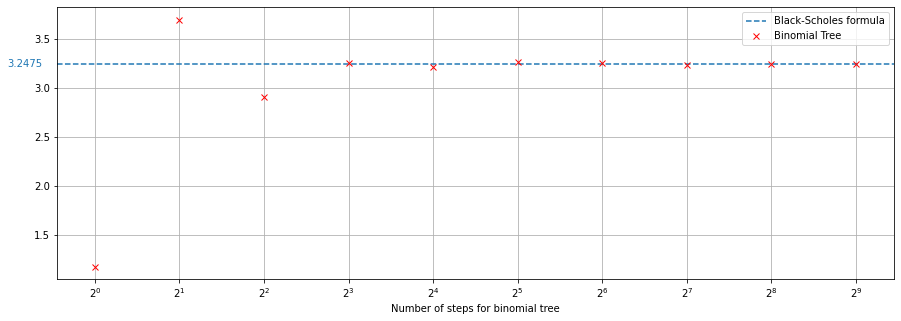

In [7]:
Ns = list(map(lambda i: 2 ** i, range(10)))
c = black_scholes(S0, K, T, r, sig, 'call')

fig = plt.figure(figsize=(15, 5))
ax = plt.gca()

ax.axhline(c, color='tab:blue', linestyle='--', label='Black-Scholes formula')
ax.text(0.65, c, f'{c:.4f}', color='tab:blue', ha="right", va="center")

ax.plot(Ns, list(map(lambda n: binomial_tree(n, S0, K, T, r, sig), Ns)), 'xr', label='Binomial Tree')
ax.set_xscale('log', base=2)
ax.set_xlabel('Number of steps for binomial tree')
ax.set_xticks(Ns)

ax.grid('on')
ax.legend()
plt.show()

# Implied Volatility from Binomial Prices (Bisection Method)

In [8]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import bisect

# --- Black–Scholes call price ---
def bs_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0 * st.norm.cdf(d1) - K * np.exp(-r*T) * st.norm.cdf(d2)

# --- Binomial tree pricer from Ex.9 ---
def binomial_call(S0, K, T, r, sigma, steps):
    dt = T/steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d) / (u - d)
    # Terminal payoffs
    ST = S0 * u**np.arange(steps, -1, -1) * d**np.arange(0, steps+1)
    C = np.maximum(ST - K, 0)
    # Backward induction
    for i in range(steps-1, -1, -1):
        C = np.exp(-r*dt) * (p*C[1:] + (1-p)*C[:-1])
    return C[0]

# --- Manual bisection for implied volatility ---
def implied_vol_bisection(C_target, S0, K, T, r, tol=1e-6, maxiter=100):
    low, high = 1e-4, 2.0
    for _ in range(maxiter):
        mid = 0.5*(low + high)
        price_mid = bs_call_price(S0, K, T, r, mid)
        if abs(price_mid - C_target) < tol:
            return mid
        if price_mid < C_target:
            low = mid
        else:
            high = mid
    return 0.5*(low + high)

# --- SciPy bisect variant ---
def implied_vol_bisect_scipy(C_target, S0, K, T, r):
    func = lambda vol: bs_call_price(S0, K, T, r, vol) - C_target
    return bisect(func, 1e-4, 2.0, xtol=1e-6)

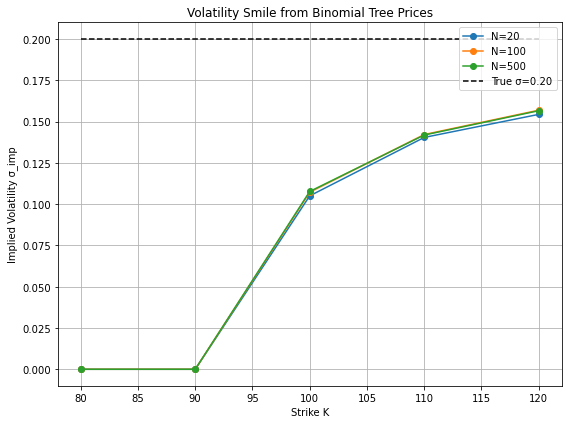

In [11]:
#  --- Parameters & strike/depth grids ---
S0, T, r, true_sigma = 100, 1.0, 0.05, 0.20
strikes = [80, 90, 100, 110, 120]
depths = [20, 100, 500]

plt.figure(figsize=(8,6))
for N in depths:
    imp_vols = []
    for K in strikes:
        C_tree = binomial_call(S0, K, T, r, true_sigma, N)
        # pick one of the two:
        sigma_imp = implied_vol_bisection(C_tree, S0, K, T, r)
        # sigma_imp = implied_vol_bisect_scipy(C_tree, S0, K, T, r)
        imp_vols.append(sigma_imp)
    plt.plot(strikes, imp_vols, 'o-', label=f'N={N}')

plt.hlines(true_sigma, strikes[0], strikes[-1], colors='k', linestyles='--',
           label='True σ=0.20')
plt.xlabel('Strike K')
plt.ylabel('Implied Volatility σ_imp')
plt.title('Volatility Smile from Binomial Tree Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()